# Quasi-criticality in the Cortex

In [2]:
'''Setup notebook environment -q flag suppresses output, if you want to see it, remove the -q flag'''
%pip install -r requirements.txt -q
from utils.plotting_utils import power_law_plot
from utils.data_utils import load_data_csv

Note: you may need to restart the kernel to use updated packages.


In [3]:
pattern_one = load_data_csv("data/with_pattern.csv")
no_pattern = load_data_csv("data/new_run_func.csv")

In [4]:
print(pattern_one.head())
print(pattern_one.describe())

   size  duration
0     4         1
1     4         1
2     2         1
3     4         1
4     3         1
              size  duration
count  6957.000000    6957.0
mean     20.782809       1.0
std      41.841789       0.0
min       1.000000       1.0
25%       2.000000       1.0
50%       4.000000       1.0
75%      13.000000       1.0
max     219.000000       1.0


In [5]:
print(no_pattern.head())
print(no_pattern.describe())

   size  duration
0    16         1
1    44         4
2    11         1
3     9         1
4    13         1
               size      duration
count  10000.000000  10000.000000
mean      12.478000      1.110100
std        4.426316      0.384698
min        2.000000      1.000000
25%       10.000000      1.000000
50%       12.000000      1.000000
75%       15.000000      1.000000
max       80.000000      6.000000


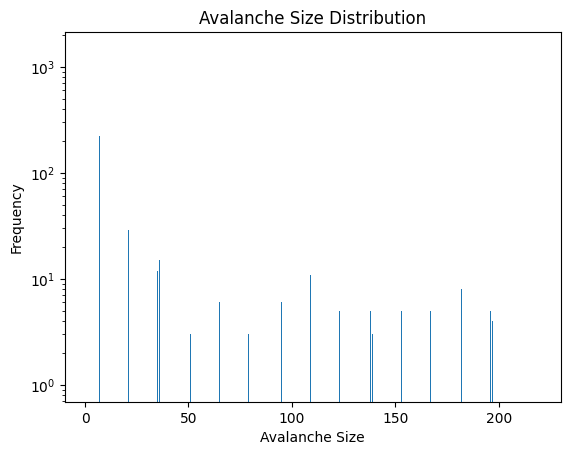

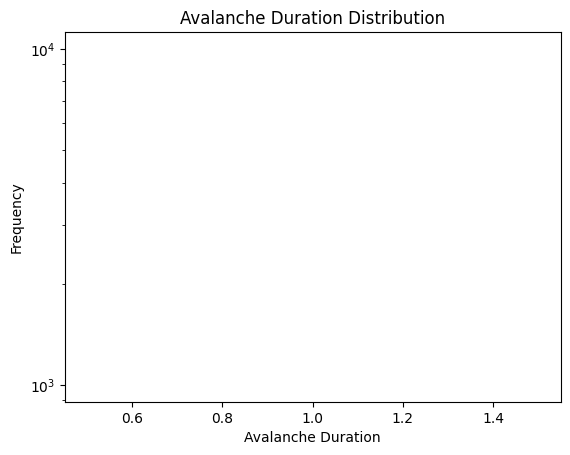

In [6]:
# For avalache sizes
power_law_plot(pattern_one['size'], data_type='size')

# For avalanche durations
power_law_plot(pattern_one['duration'], data_type='duration')

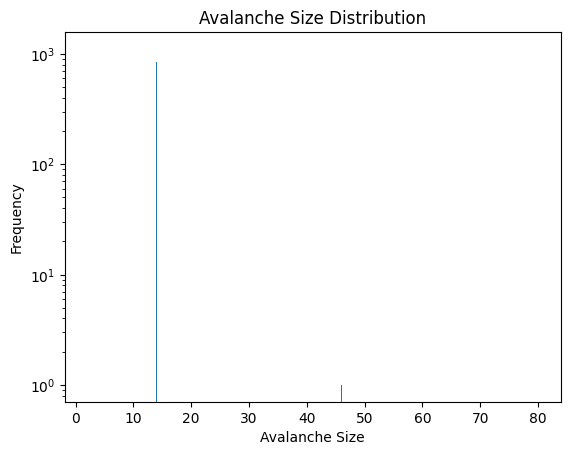

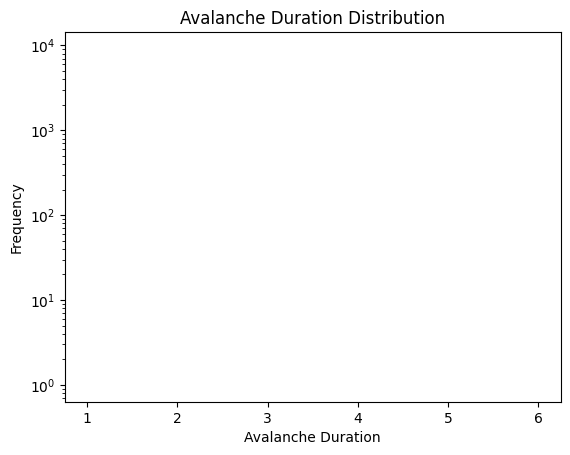

In [7]:
power_law_plot(no_pattern['size'], data_type='size')
power_law_plot(no_pattern['duration'], data_type='duration')